# 🌳 Simulación de Árbol Galton-Watson con Espina

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------- Muestreos --------
def sample_pk_geometric(rng):
    # pk = 1/2^{k+1}, k>=0  => Geometrica(0.5) - 1
    return rng.geometric(0.5) - 1

def sample_rhok_size_biased(rng):
    # rho_k = k / 2^{k+1}, k>=1  (usamos la funcion de distribucion CDF: F(n)=1-(n+2)/2^{n+1})
    u = rng.random()
    n = 1
    while True:
        if u <= 1 - (n + 2) / (2 ** (n + 1)):
            return n
        n += 1

# -------- Generación del árbol con espina + niveles con orden estable --------
def generate_gw_tree_with_spine_levels(max_profundidad=6, seed=42):
    rng = np.random.default_rng(seed)
    siguiente_id = 0
    nodos = {siguiente_id: {'profundidad': 0, 'espina': True}}; siguiente_id += 1
    aristas = []
    nodos_por_nivel = {0: [0]}      # dict: profundidad -> lista de nodos EN ORDEN
    raiz_actual = 0

    for profundidad in range(max_profundidad):
        # aseguro listas para niveles siguientes
        nodos_por_nivel.setdefault(profundidad+1, [])
        nodos_por_nivel.setdefault(profundidad+2, [])

        # hijos del padre de la espina en este nivel (k ~ rho)
        k_sp = sample_rhok_size_biased(rng)
        hijos_espina = []
        for _ in range(k_sp):
            nid = siguiente_id; siguiente_id += 1
            nodos[nid] = {'profundidad': profundidad+1, 'espina': False}
            aristas.append((raiz_actual, nid))
            hijos_espina.append(nid)
            # *** orden estable: apendo en el orden de creación ***
            nodos_por_nivel[profundidad+1].append(nid)

        # si no hubo hijos, terminamos
        if not hijos_espina:
            break

        # elegimos nuevo padre de la espina y marcamos
        siguiente_raiz = rng.choice(hijos_espina)
        nodos[siguiente_raiz]['espina'] = True

        # los otros hijos generan nietos con pk; quedan contiguos y en orden
        for c in hijos_espina:
            if c == siguiente_raiz:
                continue
            k = sample_pk_geometric(rng)
            for _ in range(k):
                nid = siguiente_id; siguiente_id += 1
                nodos[nid] = {'profundidad': profundidad+2, 'espina': False}
                aristas.append((c, nid))
                nodos_por_nivel[profundidad+2].append(nid)

        raiz_actual = siguiente_raiz

    return nodos, aristas, nodos_por_nivel

# -------- Dibujo sin cruces (por niveles y en orden) --------
def draw_tree_layered_noncross(nodos, aristas, nodos_por_nivel):
    # posición x = índice en la lista ordenada del nivel; y = -profundidad
    pos = {}
    for d in sorted(nodos_por_nivel.keys()):
        for i, nid in enumerate(nodos_por_nivel[d]):
            pos[nid] = (i, -d)

    plt.figure(figsize=(12, 7))
    # aristas (entre niveles consecutivos; sin cruces por construcción)
    for u, v in aristas:
        x1, y1 = pos[u]; x2, y2 = pos[v]
        plt.plot([x1, x2], [y1, y2])

    # nodos (espina en rojo)
    xs, ys, cols = [], [], []
    for nid, (x, y) in pos.items():
        xs.append(x); ys.append(y)
        cols.append('red' if nodos[nid].get('espina', False) else 'lightgray')
    plt.scatter(xs, ys, c=cols, s=300)
    for nid, (x, y) in pos.items():
        plt.text(x, y, str(nid), ha='center', va='center', fontsize=8)

    plt.title("Árbol de Galton–Watson con espina — layout por niveles sin cruces")
    plt.axis('off')
    plt.show()

# ---- Demo
nodos, aristas, nodos_por_nivel = generate_gw_tree_with_spine_levels(max_profundidad=10, seed=7)

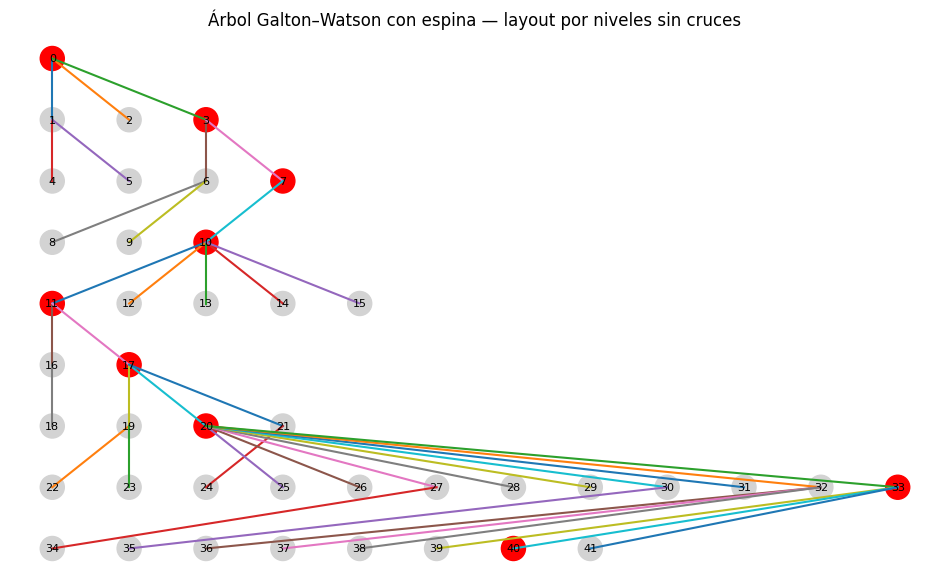

In [ ]:
draw_tree_layered_noncross(nodes, edges, level_nodes)

In [ ]:
!pip install graphviz

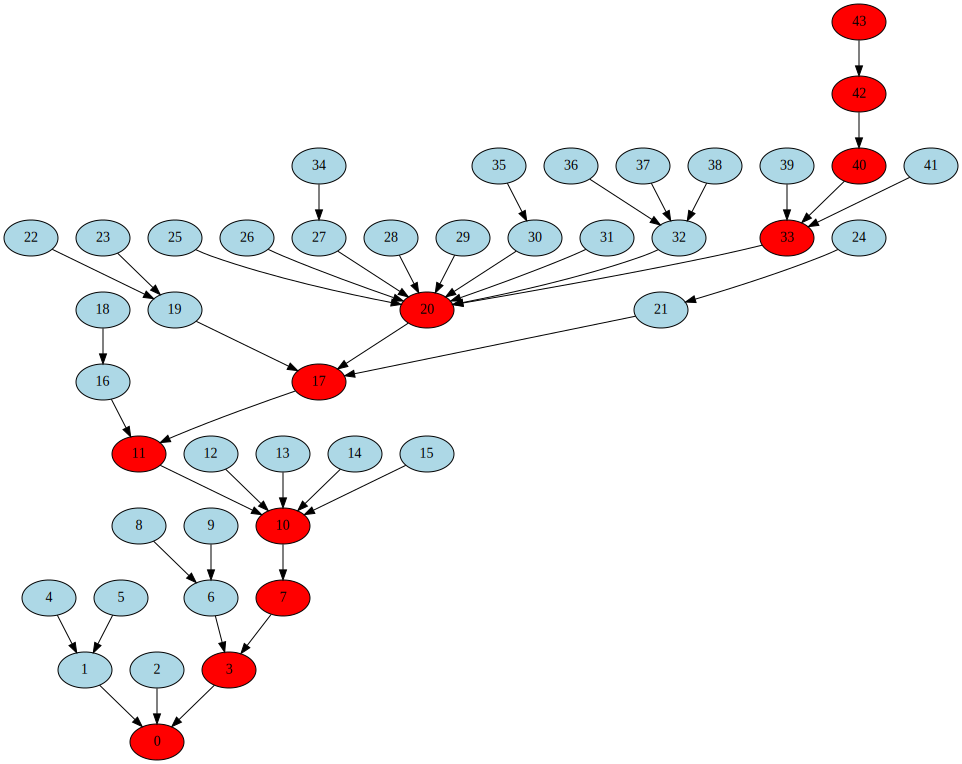

In [ ]:
import graphviz

def draw_tree_graphviz(nodos, aristas, invertir_aristas=False):
    dot = graphviz.Digraph(comment='Árbol de Galton-Watson con Espina', strict=True) # strict=True helps prevent parallel edges

    # Add nodes with color based on spine property
    for nid, data in nodos.items():
        color = 'red' if data.get('espina', False) else 'lightblue'
        dot.node(str(nid), label=str(nid), style='filled', fillcolor=color)

    # Add edges
    for u, v in aristas:
        if invertir_aristas:
            dot.edge(str(v), str(u)) # Reverse the edge direction
        else:
            dot.edge(str(u), str(v))

    # Render the graph
    display(dot)

# Draw the tree using graphviz with reversed edges
draw_tree_graphviz(nodos, aristas, invertir_aristas=True)

Estimación de p_c (finito, por spanning hasta el último nivel): 0.700


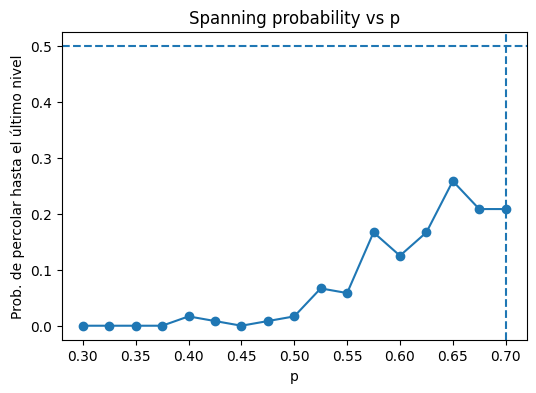

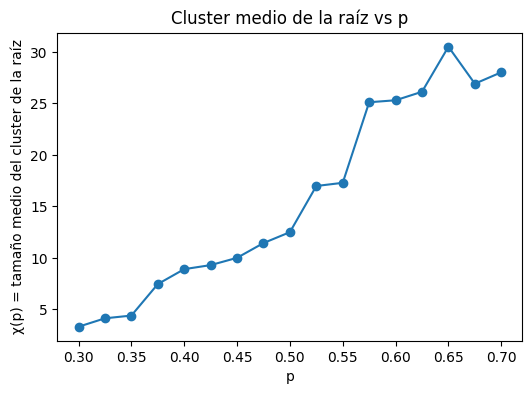

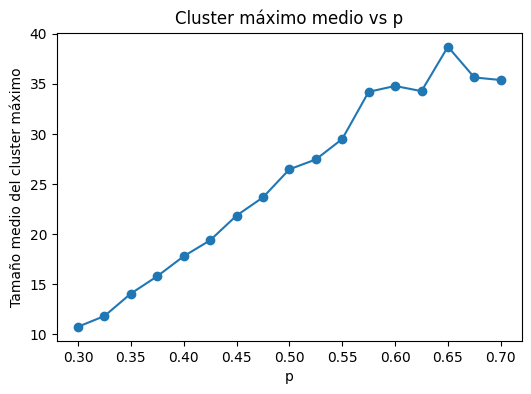

In [ ]:
import numpy as np
from collections import deque, defaultdict
import matplotlib.pyplot as plt

# ---------- 1) Construcción de triangulación a partir de niveles ----------
def build_triangulation(nodos, aristas, nodos_por_nivel):
    """
    Dado:
      - nodos: dict id -> {'profundidad': d, 'espina': bool}
      - aristas: lista de (u,v) (tipo-tiempo: padre->hijo)
      - nodos_por_nivel: dict d -> [nodos en ese nivel en orden estable]
    Devuelve:
      - edges_all: lista de aristas no dirigidas (tuplas ordenadas (a,b) con a<b)
      - root_id: id de la raíz (nivel 0)
      - levels: lista de listas de nodos por nivel (en orden)
    """
    # 1) aristas de tiempo (del árbol)
    time_edges = set()
    for u, v in aristas:
        a, b = (u, v) if u < v else (v, u)
        time_edges.add((a, b))

    # 2) aristas de espacio (conexiones circulares en cada nivel)
    space_edges = set()
    niveles_ordenados = sorted(nodos_por_nivel.keys())
    levels = []
    for d in niveles_ordenados:
        lvl = nodos_por_nivel[d]
        if len(lvl) == 0:
            levels.append([])
            continue
        levels.append(list(lvl))
        if len(lvl) >= 2:
            for i in range(len(lvl)):
                a = lvl[i]
                b = lvl[(i+1) % len(lvl)]  # circular
                x, y = (a, b) if a < b else (b, a)
                space_edges.add((x, y))
        else:
            # con 1 nodo, no añadimos lazo (en la triangulación real sería un loop)
            pass

    edges_all = sorted(list(time_edges | space_edges))
    root_id = levels[0][0]  # la raíz es el único nodo del nivel 0 en nuestra construcción
    return edges_all, root_id, levels

# ---------- 2) Percolación: abrir/cerrar aristas y BFS de componentes ----------
def percolate_and_clusters(edges, p):
    """
    edges: lista de aristas (a,b) con a<b
    p: probabilidad de abrir la arista

    Retorna:
      - open_adj: dict nodo -> lista de vecinos por aristas abiertas
      - components: lista de listas de nodos (componentes conexas por aristas abiertas)
    """
    rng = np.random.default_rng()
    open_adj = defaultdict(list)
    for a, b in edges:
        if rng.random() < p:
            open_adj[a].append(b)
            open_adj[b].append(a)

    # BFS para componentes
    visited = set()
    components = []
    for u in open_adj.keys():
        if u in visited:
            continue
        comp = []
        q = deque([u])
        visited.add(u)
        while q:
            x = q.popleft()
            comp.append(x)
            for y in open_adj[x]:
                if y not in visited:
                    visited.add(y)
                    q.append(y)
        components.append(comp)

    # incluir nodos aislados (sin aristas abiertas) si quieres contarlos como componentes de tamaño 1
    # (opcional: comentado si no deseas)
    # all_nodes = set()
    # for a,b in edges:
    #     all_nodes.add(a); all_nodes.add(b)
    # for u in all_nodes:
    #     if u not in open_adj and u not in visited:
    #         components.append([u])

    return open_adj, components

def cluster_of_node(open_adj, start):
    """ Devuelve los nodos del cluster que contiene a 'start' (si start no tiene aristas, tamaño 1). """
    if start not in open_adj:
        return [start]
    visited = set([start])
    q = deque([start])
    comp = []
    while q:
        x = q.popleft()
        comp.append(x)
        for y in open_adj[x]:
            if y not in visited:
                visited.add(y)
                q.append(y)
    return comp

# ---------- 3) Observables ----------
def spans_to_last_level(open_adj, levels, root_id):
    """
    Chequea si existe un camino abierto desde la raíz hasta cualquier nodo del último nivel.
    """
    last_level_nodes = set(levels[-1]) if len(levels) > 1 else set()
    if not last_level_nodes:
        return False
    # BFS desde raíz en el grafo de aristas abiertas
    if root_id not in open_adj:
        return False
    visited = set([root_id])
    q = deque([root_id])
    while q:
        x = q.popleft()
        if x in last_level_nodes:
            return True
        for y in open_adj[x]:
            if y not in visited:
                visited.add(y)
                q.append(y)
    return False

def run_one_realization(max_profundidad, p, seed=None):
    """
    Genera un árbol con espina -> triangula niveles -> percola con prob. p.
    Retorna:
      - size_root_cluster
      - size_max_cluster
      - spans (bool)
      - n_nodes
    """
    # 1) árbol + niveles (usa tu función ya definida)
    nodos, aristas, nodos_por_nivel = generate_gw_tree_with_spine_levels(
        max_profundidad=max_profundidad, seed=np.random.SeedSequence().entropy if seed is None else seed
    )
    # 2) triangulación (tiempo + espacio)
    edges_all, root_id, levels = build_triangulation(nodos, aristas, nodos_por_nivel)
    # 3) percolación
    open_adj, components = percolate_and_clusters(edges_all, p)
    # 4) observables
    root_cluster = cluster_of_node(open_adj, root_id)
    size_root = len(root_cluster)
    size_max = max((len(c) for c in components), default=1)
    span = spans_to_last_level(open_adj, levels, root_id)

    # número total de nodos útiles (para normalizaciones si quieres)
    all_nodes = set()
    for a,b in edges_all:
        all_nodes.add(a); all_nodes.add(b)
    n_nodes = len(all_nodes)
    return size_root, size_max, span, n_nodes

# ---------- 4) Barrido en p y estimación de pc ----------
def sweep_p_estimates(max_profundidad=8, p_grid=None, n_runs=200, seed=1234):
    """
    Corre varias realizaciones para cada p, y estima:
      - chi(p): tamaño medio del cluster de la raíz
      - max_cluster(p): tamaño medio del cluster máximo
      - span_prob(p): prob. de percolar hasta el último nivel
    """
    rng = np.random.default_rng(seed)
    if p_grid is None:
        # Sabemos por teoría que pc <= 0.5; barremos alrededor
        p_grid = np.linspace(0.30, 0.70, 17)

    chi = []
    cmax = []
    span_prob = []

    for p in p_grid:
        sizes_root = []
        sizes_max = []
        spans = []
        for _ in range(n_runs):
            sr, sm, sp, _ = run_one_realization(max_profundidad, p, seed=rng.integers(0, 10**9))
            sizes_root.append(sr)
            sizes_max.append(sm)
            spans.append(1 if sp else 0)
        chi.append(np.mean(sizes_root))
        cmax.append(np.mean(sizes_max))
        span_prob.append(np.mean(spans))

    return np.array(p_grid), np.array(chi), np.array(cmax), np.array(span_prob)

def estimate_pc_from_span(p_grid, span_prob):
    """
    Estima p_c como el p donde la probabilidad de 'spanning' cruza 0.5.
    Interpolación lineal simple entre los puntos más cercanos.
    """
    idx = np.searchsorted(span_prob, 0.5)
    if idx == 0:
        return p_grid[0]
    if idx >= len(p_grid):
        return p_grid[-1]
    # interp lineal
    x0, x1 = p_grid[idx-1], p_grid[idx]
    y0, y1 = span_prob[idx-1], span_prob[idx]
    if y1 == y0:
        return x0
    return x0 + (0.5 - y0) * (x1 - x0) / (y1 - y0)

# ---------- 5) Demo rápida ----------
if __name__ == "__main__":
    p_grid, chi, cmax, span_prob = sweep_p_estimates(max_profundidad=9, n_runs=120, seed=7)

    pc_hat = estimate_pc_from_span(p_grid, span_prob)
    print(f"Estimación de p_c (finito, por spanning hasta el último nivel): {pc_hat:.3f}")

    # Gráficos (sin fijar colores/estilos específicos)
    plt.figure(figsize=(6,4))
    plt.plot(p_grid, span_prob, marker='o')
    plt.axhline(0.5, linestyle='--')
    plt.axvline(pc_hat, linestyle='--')
    plt.xlabel("p"); plt.ylabel("Prob. de percolar hasta el último nivel")
    plt.title("Spanning probability vs p")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(p_grid, chi, marker='o')
    plt.xlabel("p"); plt.ylabel("χ(p) = tamaño medio del cluster de la raíz")
    plt.title("Cluster medio de la raíz vs p")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(p_grid, cmax, marker='o')
    plt.xlabel("p"); plt.ylabel("Tamaño medio del cluster máximo")
    plt.title("Cluster máximo medio vs p")
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def draw_cylinder_percolation(levels, edges_all, open_adj, nodos=None, show_nodes=True, mark_spine=True):
    """
    levels    : lista de niveles, cada uno es una lista de ids de nodos (en orden)
    edges_all : lista de aristas (a,b) con a<b (tiempo + espacio)
    open_adj  : dict nodo -> lista de vecinos (solo aristas abiertas)
    nodos     : dict opcional id -> {'profundidad': int, 'espina': bool} para marcar espina
    show_nodes: dibujar puntos de nodos
    mark_spine: si hay 'nodos', resaltar la espina (solo cambia el tamaño del punto)

    Dibuja:
      - aristas abiertas como línea continua
      - aristas cerradas como línea punteada
    """
    # Posiciones: cada nivel sobre una circunferencia; niveles apilados en y
    pos = {}
    y_gap = 2.0       # separación vertical entre niveles
    R = 3.0           # radio de las circunferencias
    for d, lvl in enumerate(levels):
        m = max(len(lvl), 1)
        # ángulos iguales; el orden en 'levels[d]' determina la vecindad espacial
        thetas = np.linspace(0, 2*np.pi, m, endpoint=False) if m > 1 else np.array([0.0])
        for j, nid in enumerate(lvl):
            x = R*np.cos(thetas[j])
            y = -d*y_gap
            pos[nid] = (x, y)

    # Conjunto de aristas abiertas (clave ordenada a<b)
    open_set = set()
    for u, neigh in open_adj.items():
        for v in neigh:
            a, b = (u, v) if u < v else (v, u)
            open_set.add((a, b))

    # Dibujo
    plt.figure(figsize=(10, 8))

    # 1) Aristas: abiertas (línea continua) y cerradas (línea punteada)
    for a, b in edges_all:
        x1, y1 = pos[a]; x2, y2 = pos[b]
        if (a, b) in open_set:
            plt.plot([x1, x2], [y1, y2], linestyle='-', linewidth=1.8)
        else:
            plt.plot([x1, x2], [y1, y2], linestyle='--', linewidth=1.2)

    # 2) Nodos (opcional)
    if show_nodes:
        xs, ys, sizes = [], [], []
        for d, lvl in enumerate(levels):
            for nid in lvl:
                x, y = pos[nid]
                xs.append(x); ys.append(y)
                # marcar espina con tamaño mayor (si se provee 'nodos')
                if mark_spine and nodos is not None and nodos.get(nid, {}).get('espina', False):
                    sizes.append(80)
                else:
                    sizes.append(30)
        plt.scatter(xs, ys, s=sizes, zorder=3)

    # 3) (Opcional) líneas de las circunferencias (solo guía visual)
    # for d, lvl in enumerate(levels):
    #     ang = np.linspace(0, 2*np.pi, 200)
    #     plt.plot(R*np.cos(ang), -d*y_gap + R*0*ang)  # eje de guía

    plt.title("Triangulación causal en el cilindro: aristas abiertas (—) y cerradas (--)")
    plt.axis('equal'); plt.axis('off')
    plt.show()


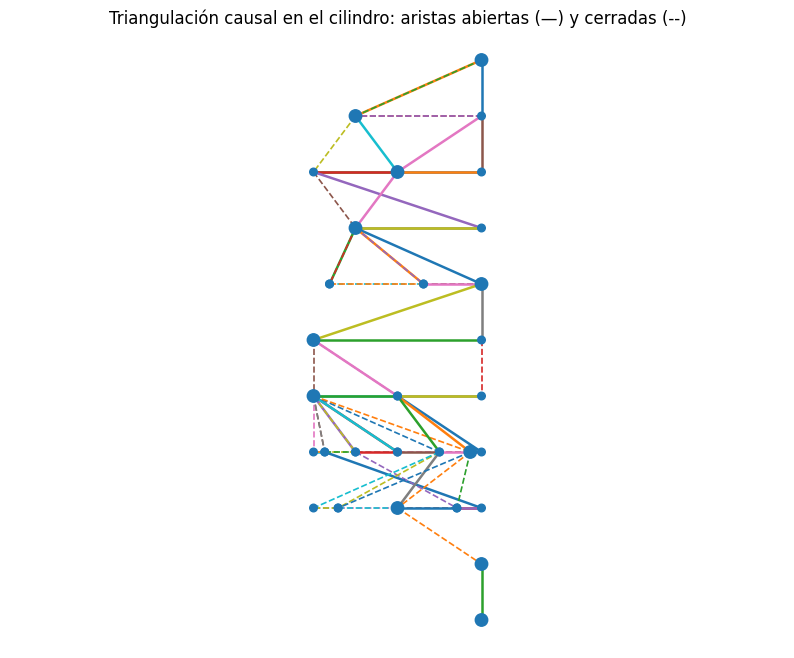

In [ ]:
# Para dibujar el gráfico de cilindro con percolación, necesitamos ejecutar una realización completa
# que incluya la generación del árbol, la triangulación y la percolación.
# Usaremos la función run_one_realization para esto.

# Puedes ajustar los parámetros (profundidad, probabilidad de percolación p) aquí:
max_profundidad_cilindro = 10  # Por ejemplo, 10 niveles
prob_percolacion_p = 0.5      # Probabilidad de abrir una arista

# Ejecutar una realización para obtener los datos de la percolación
# La función run_one_realization devuelve tamaño_raiz, tamaño_max, spanning y n_nodos
# Pero no devuelve directamente open_adj ni los datos del arbol y niveles que necesitamos para dibujar.
# Tendremos que modificar un poco para obtener open_adj y levels si queremos usar draw_cylinder_percolation.

# Alternativa: Llamar directamente a las funciones intermedias si necesitamos más control
# Generar el arbol de nuevo para esta visualización
nodos_cil, aristas_cil, nodos_por_nivel_cil = generate_gw_tree_with_spine_levels(max_profundidad=max_profundidad_cilindro, seed=7)

# Construir la triangulación
edges_all_cil, root_id_cil, levels_cil = build_triangulation(nodos_cil, aristas_cil, nodos_por_nivel_cil)

# Realizar la percolación para obtener las aristas abiertas
open_adj_cil, components_cil = percolate_and_clusters(edges_all_cil, prob_percolacion_p)

# Dibujar el gráfico de cilindro con la percolación
draw_cylinder_percolation(levels_cil, edges_all_cil, open_adj_cil, nodos=nodos_cil, show_nodes=True, mark_spine=True)

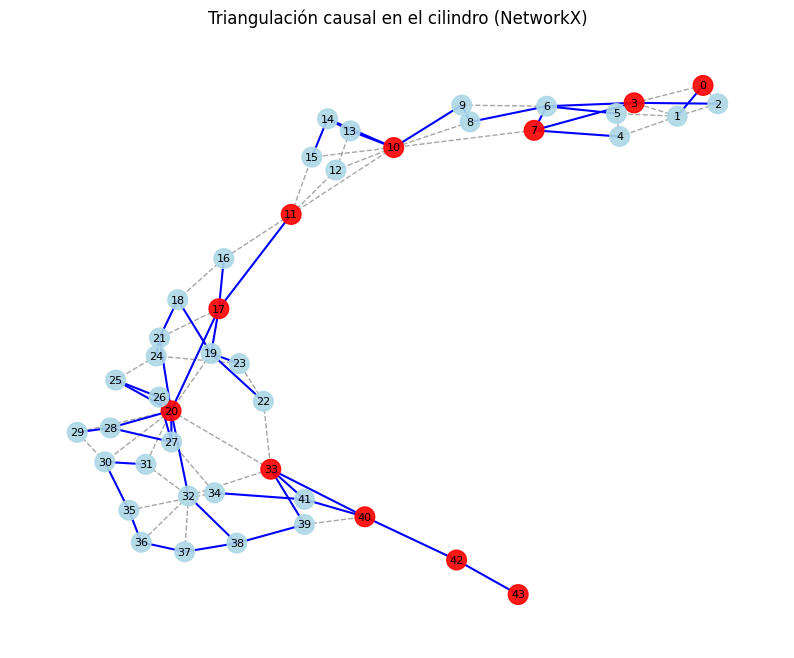

In [ ]:
import networkx as nx

# Crear un grafo no dirigido con networkx a partir de todas las aristas (tiempo + espacio)
G_cilindro = nx.Graph()

# Añadir nodos con atributos (por ejemplo, si están en la espina)
for nid, data in nodos_cil.items():
    G_cilindro.add_node(nid, espina=data.get('espina', False))

# Añadir todas las aristas (tiempo y espacio)
G_cilindro.add_edges_from(edges_all_cil)

# Podemos usar un layout de networkx, por ejemplo 'spring_layout'
# pos_cilindro = nx.spring_layout(G_cilindro)
# O, para intentar mantener una estructura similar a la de niveles, podríamos adaptar las posiciones
# de la visualización anterior, o usar un layout especializado si networkx lo tuviera para cilindros.
# Por ahora, usemos el spring_layout como una alternativa general.
pos_cilindro = nx.spring_layout(G_cilindro)


plt.figure(figsize=(10, 8))

# Dibujar aristas: diferenciando abiertas y cerradas
open_edges_set_cil = set()
for u, neigh in open_adj_cil.items():
    for v in neigh:
        a, b = (u, v) if u < v else (v, u)
        open_edges_set_cil.add((a, b))

closed_edges_cil = [(u, v) for u, v in G_cilindro.edges() if (u, v) not in open_edges_set_cil and (v, u) not in open_edges_set_cil]
open_edges_cil = list(open_edges_set_cil)

nx.draw_networkx_edges(G_cilindro, pos_cilindro, edgelist=closed_edges_cil, edge_color='gray', style='dashed', alpha=0.7)
nx.draw_networkx_edges(G_cilindro, pos_cilindro, edgelist=open_edges_cil, edge_color='blue', width=1.5)


# Dibujar nodos: diferenciando espina
node_colors = ['red' if G_cilindro.nodes[n].get('espina', False) else 'lightblue' for n in G_cilindro.nodes()]
nx.draw_networkx_nodes(G_cilindro, pos_cilindro, node_color=node_colors, node_size=200, alpha=0.9)

# Opcional: dibujar etiquetas de nodos
nx.draw_networkx_labels(G_cilindro, pos_cilindro, font_size=8)

plt.title("Triangulación causal en el cilindro (NetworkX)")
plt.axis('off') # Hide axes
plt.show()